<a href="https://colab.research.google.com/github/alyssonmazoni/scielo_relational_model/blob/main/Scielo_relational_model_reference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scielo relational model

Scripts to convert the Scielo database of works into a relational model.

Previous step is to convert the XML files into JSON objects and upload all of them into a single table inside Big Query with one column containg a JSON string. One work each row. 

## Preparation

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Origin of data

### Scielo metadata as a dump

Compressed file with most of Scielo metadata provided by Scielo:

http://static.scielo.org/articlemeta/scielo_articles.zip 

When uncompressed it producess a bulk of XML files. Each file is the metadata for a work. The XML can be read in Python as a dictionary and imported into a JSON string row in a table. Here the table is called `scielo_works`.

In [ ]:
# Symbols @ inherited from the conversion to JSON are erased into a new table.
%%bigquery --project=insyspo

DROP TABLE `insyspo.projectdb_scielo_rm.works_json`;
CREATE TABLE `insyspo.projectdb_scielo_rm.works_json` AS (
  SELECT REPLACE(
          REPLACE(
            REPLACE(work, '#', '')
          , '@','')
         ,"'",'"' AS work
FROM `insyspo.publicdb_scielo.scielo_works`);


# Diagram of tables
[Diagram](scielo_rm_sketch.png)

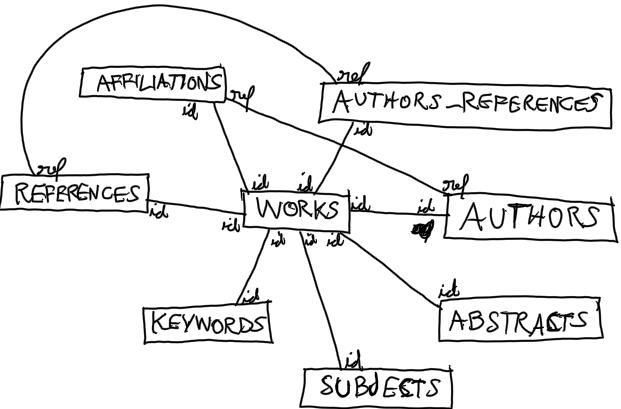

## Works

Table with information about works. 

Difficulties:

- Name of field with work id varies. ˋunique-article-idˋ, ˋarticle-idˋ, ˋarticle-id[0]ˋ.
- Same for DOI, ˋarticle-id[0]ˋ and what else...
- Disambiguate journals?


In [ ]:
%%bigquery --project=insyspo

DROP TABLE `insyspo.projectdb_scielo_rm.works_fjs`;
CREATE TABLE `insyspo.projectdb_scielo_rm.works_fjs` AS (
SELECT  COALESCE(
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.unique-article-id.text'), 
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.article-id[0].text'),
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.article-id.text')  
        ) AS id,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.article-id[1].text') AS doi,
        COALESCE(
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.title-group.article-title.text'), 
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.title-group.article-title[0].text') 
        ) AS title,
        JSON_EXTRACT(
          work, 
          '$.articles.article.lang_id') AS lang, 
        JSON_EXTRACT(
          work, 
          '$.articles.article.article-type') AS type,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.journal-meta.journal-id.text') AS journal_id, 
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.journal-meta.journal-id.journal-id-type') AS journal_type,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.journal-meta.journal-title-group.journal-title') AS journal, 
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.journal-meta.journal-title-group.abbrev-journal-title') AS abbrev_journal,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.journal-meta.issn') AS issn,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.journal-meta.collection') AS collection,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.journal-meta.publisher.publisher-name') AS publisher,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.article-categories.subj-group.subject') AS subjects,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.pub-date.year') AS pub_year,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.pub-date.month') AS pub_month,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.volume') AS volume,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.issue') AS issue,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.lpage') AS lpage,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.fpage') AS fpage,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.permissions.license.license-type') AS license,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.kwd-group') AS keywords,
FROM `insyspo.projectdb_scielo_rm.works_json`
);


Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'works_fjs'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,doi
2,title
3,lang
4,type
5,journal_id
6,journal_type
7,journal
8,abbrev_journal
9,issn


## Abstracts

In [ ]:
%%bigquery --project=insyspo

DROP TABLE `insyspo.projectdb_scielo_rm.abstracts_fjs`;
CREATE TABLE `insyspo.projectdb_scielo_rm.abstracts_fjs` AS (
SELECT  COALESCE(
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.unique-article-id.text'), 
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.article-id[0].text'),
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.article-id.text')  
        ) AS id,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.abstract.lang_id') AS lang_id,
        JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.abstract.p') AS text,
FROM `insyspo.projectdb_scielo_rm.works_json`
WHERE JSON_EXTRACT(
          work, 
          '$.articles.article.front.article-meta.abstract.p') IS NOT NULL
);


Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'abstracts_fjs'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,lang_id
2,text


## Subjects

In [ ]:
%%bigquery --project=insyspo

DROP TABLE insyspo.projectdb_scielo_rm.subjects_fjs;
CREATE TABLE insyspo.projectdb_scielo_rm.subjects_fjs AS (
  WITH subjects_fjs AS (
    SELECT id, 
      JSON_EXTRACT_ARRAY(subjects,'$') AS subjects
    FROM insyspo.projectdb_scielo_rm.works_fjs
    WHERE subjects IS NOT NULL
  )
  SELECT id,
    TRIM(subject,'"') AS subject
  FROM subjects_fjs,
  UNNEST(subjects) subject
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'subjects_fjs'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,subject


## Authors

In [ ]:
%%bigquery --project=insyspo

DROP TABLE `insyspo.projectdb_scielo_rm.authors_fjs`;
CREATE TABLE `insyspo.projectdb_scielo_rm.authors_fjs` AS (
  WITH authors_fjs AS (
    SELECT COALESCE(
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.unique-article-id.text'), 
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.article-id[0].text'),
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.article-id.text')  
        ) AS id,
          JSON_EXTRACT_ARRAY(
            work, 
            '$.articles.article.front.article-meta.contrib-group.contrib') AS authors
    FROM `insyspo.projectdb_scielo_rm.works_json`
  )
  SELECT id, 
    JSON_EXTRACT(author,'$.name.surname') AS surname,
    JSON_EXTRACT(author,'$.name.given-names') AS given_names,
    JSON_EXTRACT(author,'$.xref.rid') AS ref,
  FROM authors_fjs,
  UNNEST(authors) author
);


Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'authors_fjs'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,surname
2,given_names
3,ref


## Affiliations



In [ ]:
%%bigquery --project=insyspo

DROP TABLE `insyspo.projectdb_scielo_rm.affiliations_fjs`;
CREATE TABLE `insyspo.projectdb_scielo_rm.affiliations_fjs` AS (
  WITH affiliations_fjs AS (
    SELECT COALESCE(
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.unique-article-id.text'), 
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.article-id[0].text'),
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.article-id.text')  
        ) AS id,
          JSON_EXTRACT_ARRAY(
            work, 
            '$.articles.article.front.article-meta.aff') AS affiliations
    FROM `insyspo.projectdb_scielo_rm.works_json`
  )
  SELECT id, 
    JSON_EXTRACT(affiliation,'$.id') AS ref,
    JSON_EXTRACT(affiliation,'$.institution') AS institution,
    JSON_EXTRACT(affiliation,'$.country') AS country,
  FROM affiliations_fjs,
  UNNEST(affiliations) affiliation
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'affiliations_fjs'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,ref
2,institution
3,country


## References

Works referenced. They are usually not part of Scielo.

In [ ]:
%%bigquery --project=insyspo

DROP TABLE `insyspo.projectdb_scielo_rm.references_fjs`;
CREATE TABLE `insyspo.projectdb_scielo_rm.references_fjs` AS (
  WITH references_fjs AS (
    SELECT  COALESCE(
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.unique-article-id.text'), 
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.article-id[0].text'),
          JSON_EXTRACT(
            work, 
            '$.articles.article.front.article-meta.article-id.text')  
        ) AS id,
          JSON_EXTRACT_ARRAY(
            work, 
            '$.articles.article.back.ref-list.ref') AS references
    FROM `insyspo.projectdb_scielo_rm.works_json`
  )
  SELECT id, 
    JSON_EXTRACT(reference,'$.id') AS ref,
    JSON_EXTRACT(reference,'$.element-citation.publication-type') AS type,
    JSON_EXTRACT(reference,'$.element-citation.source') AS source,
    JSON_EXTRACT(reference,'$.element-citation.article-title') AS title,
    JSON_EXTRACT(reference,'$.element-citation.date.year') AS year,
    JSON_EXTRACT(reference,'$.element-citation.person-group') AS authors,
  FROM references_fjs,
  UNNEST(references) reference
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'references_fjs'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,ref
2,type
3,source
4,title
5,year
6,authors


## Authors of references

In [ ]:
%%bigquery --project=insyspo

DROP TABLE `insyspo.projectdb_scielo_rm.authors_references_fjs`;
CREATE TABLE `insyspo.projectdb_scielo_rm.authors_references_fjs` AS (
    WITH authors_references_fjs AS (
    SELECT JSON_EXTRACT_ARRAY(authors,'$.name') AS authors, 
      id, 
      ref
    FROM insyspo.projectdb_scielo_rm.references_fjs
  )
  SELECT id,
    ref,
    JSON_EXTRACT(author,'$.surname') AS surname,
    JSON_EXTRACT(author,'$.given-names') AS given_names,
  FROM authors_references_fjs,
  UNNEST(authors) author
  ORDER BY id ASC, ref ASC
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'authors_references_fjs'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,ref
2,surname
3,given_names


## Keywords

In [ ]:
%%bigquery --project=insyspo

DROP TABLE `insyspo.projectdb_scielo_rm.keywords_fjs`;
CREATE TABLE `insyspo.projectdb_scielo_rm.keywords_fjs` AS (
WITH keywords_fjs AS (
  SELECT  id,
   JSON_EXTRACT(
     keyword, 
     '$.lang_id') AS lang_id,
   JSON_EXTRACT(
      keyword, 
      '$.kwd') AS kwd,          
  FROM `insyspo.projectdb_scielo_rm.works_fjs`,
  UNNEST(JSON_EXTRACT_ARRAY(keywords,'$')) keyword
)
SELECT id,
    lang_id,
    keyword
FROM keywords_fjs,
UNNEST(JSON_EXTRACT_ARRAY(kwd,'$')) keyword
ORDER BY id ASC
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project=insyspo

SELECT column_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.COLUMNS
WHERE table_name LIKE 'keywords_fjs'

Query is running:   0%|          |

Downloading:   0%|          |

,column_name
0,id
1,lang_id
2,keyword


## Tables

In [ ]:
%%bigquery --project=insyspo

SELECT table_name
FROM insyspo.projectdb_scielo_rm.INFORMATION_SCHEMA.TABLES
WHERE table_name LIKE '%_fjs'

Query is running:   0%|          |

Downloading:   0%|          |

,table_name
0,keywords_fjs
1,affiliations_fjs
2,works_fjs
3,authors_fjs
4,abstracts_fjs
5,subjects_fjs
6,authors_references_fjs
7,references_fjs


# Export to reference database

In [ ]:
%%bigquery --project=insyspo

DROP TABLE insyspo.projectdb_scielo_relational_model.works;
CREATE TABLE insyspo.projectdb_scielo_relational_model.works
COPY insyspo.projectdb_scielo_rm.works_fjs;

DROP TABLE insyspo.projectdb_scielo_relational_model.subjects;
CREATE TABLE insyspo.projectdb_scielo_relational_model.subjects
COPY insyspo.projectdb_scielo_rm.subjects_fjs;

DROP TABLE insyspo.projectdb_scielo_relational_model.authors;
CREATE TABLE insyspo.projectdb_scielo_relational_model.authors
COPY insyspo.projectdb_scielo_rm.authors_fjs;

DROP TABLE insyspo.projectdb_scielo_relational_model.references;
CREATE TABLE insyspo.projectdb_scielo_relational_model.references
COPY insyspo.projectdb_scielo_rm.references_fjs;

DROP TABLE insyspo.projectdb_scielo_relational_model.keywords;
CREATE TABLE insyspo.projectdb_scielo_relational_model.keywords
COPY insyspo.projectdb_scielo_rm.keywords_fjs;

DROP TABLE insyspo.projectdb_scielo_relational_model.authors_references;
CREATE TABLE insyspo.projectdb_scielo_relational_model.authors_references
COPY insyspo.projectdb_scielo_rm.authors_references_fjs;

DROP TABLE insyspo.projectdb_scielo_relational_model.affiliations;
CREATE TABLE insyspo.projectdb_scielo_relational_model.affiliations
COPY insyspo.projectdb_scielo_rm.affiliations_fjs;


Query is running:   0%|          |

""
